In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.stats import ttest_ind, ranksums
from decimal import Decimal
import math

# Format
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 700)
sns.set(font_scale=1.1)  

# Warnings
pd.options.mode.chained_assignment = None  # default='warn'

from matplotlib.cbook import boxplot_stats  # Para obtener los outliers en un boxplot
# boxplot_stats(df_blocks_filtered['antisaccade_errors']).pop(0)['fliers']


In [3]:
suj = "antisacadas_99"
df = pd.read_csv(f"./raw_data/{suj}.csv")
df.head(2)

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,run_id,condition,recorded_at,source_code_version,ip,user_agent,device,browser,browser_version,platform,platform_version,item_width_mm,item_height_mm,item_width_px,px2mm,view_dist_mm,item_width_deg,px2deg,win_width_deg,win_height_deg,success,timeout,failed_images,failed_audio,failed_video,jspsych_start_time,load_time,response_type,key_press,avg_frame_time,center_x,center_y,rastoc-type,stimulus-coordinate,calibration-id,calibration-point-id,inner-width,inner-height,webgazer_data,webgazer_targets,validation-id,validation-point-id,last-estimations,validation-results,isSaccadeExperiment,typeOfSaccade,isTutorial,cueShownAtLeft,itiEnd,fixEnd,intraEnd,visualEnd,responseEnd,viewportWidth,viewportHeight,systemIsStillCalibrated,events
0,65601.0,"\n <div style=""left: calc(50% - 400px); wid...",0,html-button-response,0,65605,0.0-0.0,99,1,2023-02-08 18:07:31,02ed24b7f158623ec428c7daae03df53,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24775.0,NaN,"{""anteojos"":""contacto"",""age"":""35"",""hand"":""dere...",survey-html-form,1,90383,0.0-1.0,99,1,2023-02-08 18:07:31,02ed24b7f158623ec428c7daae03df53,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def pre_processing(
    df: pd.DataFrame,
    type_of_saccade: str,
    NEW_SAMPLING_RATE=30,
    interpolate=False,
    cue_shown_at_left=None,
    threshold_to_accept_sacc=0.5,
    FILTER = 1.5,
    filter_by_block = False,
    selected_block = 1
) -> dict:
    """Pre process webcam eye tracking data

    Args:
        df (pd.DataFrame): _description_
        type_of_saccade (str): _description_
        NEW_SAMPLING_RATE (int, optional): _description_. Defaults to 30.
        interpolate (bool, optional): _description_. Defaults to False.
        cue_shown_at_left (_type_, optional): _description_. Defaults to None.
        threshold_to_accept_sacc (float, optional): _description_. Defaults to 0.5.

    Returns:
        dict: _description_
    """

    # 0. Estoy sacando los trials de practica (`isTutorial`) y quedandome con las filas que tengan datos de webgazer
    df_saccade = df.query(
        "not webgazer_data.isnull() and isTutorial == False"
    )

    # Le agrego numero de bloque al df
    blocks = sum([[i]*20 for i in range(1,17)], []) 
    df_saccade.loc[:,"block"] = blocks

    # Filtro por tipo de sacada
    df_saccade = df_saccade.query(
        "typeOfSaccade == @type_of_saccade"
    )

    # filtro por bloque
    if filter_by_block == True:
        df_saccade = df_saccade.query(
        "block == @selected_block"
    )

    
    webgazer_data = df_saccade["webgazer_data"].map(eval)

    ts_xs = []
    baseline_start = -200.0
    baseline_end = 100.0

    pro_sacc_errors = 0
    anti_sacc_errors = 0

    pro_sacc_errors_rt = []
    pro_sacc_correct_rt = []
    anti_sacc_errors_rt = []
    anti_sacc_correct_rt = []

    for trial in range(len(webgazer_data)):
        t0 = df_saccade["intraEnd"].iloc[trial]
        tf = df_saccade["fixEnd"].iloc[trial]  # Deberia ser t0 - 200
        xs = np.array([i["x"] for i in webgazer_data.iloc[trial]])
        ts = np.array([i["t"] - t0 for i in webgazer_data.iloc[trial]])

        # Interpolate
        if interpolate:
            f1 = interp1d(ts, xs, kind="linear")
            ts_new = np.linspace(-200, ts[-1], NEW_SAMPLING_RATE)
            xs = f1(ts_new)
            ts = ts_new

        # 1. Calcular la mediana entre [baseline_start baseline_end] = Xbase
        x_base = np.median(xs[(ts > baseline_start) & (ts < baseline_end)])  # [-200, 100]

        # 2. Calcular la mediana entre [500 700] (se puede antibar) = Xmax (o Xmin segun el signo)
        x_max = np.median(xs[(ts > 500.0) & (ts <= 700.0)])

        # 3. y despues transformas tal que antes de 0 sea 0 y al final sea 1 o -1
        # eso seria: (xs - Xbase) / abs(Xbase - Xmax)
        xs = (xs - x_base) / np.abs(x_base - x_max)

        # 4. Luego de normalizar las estimaciones se espejó la mitad de ellas tal que pudiera asu-
        # mirse que el estímulo visual lateral aparecía siempre del mismo lado. El espejado se realizó
        # multiplicando por −1 las estimaciones de los ensayos en los cuales el estímulo lateral
        # apareciera a izquierda. -> Por lo tanto lo que quede para arriba es mirar en la direccion del estimulo y para abajo en la direccion opuesta
        if df_saccade["cueShownAtLeft"].iloc[trial] == True:
            xs = xs * -1

        # 5. filtro pasa banda de trials
        if any(xs > FILTER) or any(xs < -FILTER):
            continue

        # 6. Savitzky-Golay filter
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
        xs = savgol_filter(xs, 5, 2)

        # 7. Detectar lado en que mira
        xs_after_baseline = xs[ts > baseline_end]
        ts_after_baseline = ts[ts > baseline_end]
        if type_of_saccade == "prosaccade":
            is_sacc_error_in_trial = np.any(
                xs_after_baseline < -threshold_to_accept_sacc
            )
            if is_sacc_error_in_trial:
                pro_sacc_errors += 1
                err_prosacc_idx = np.where(
                    xs_after_baseline < -threshold_to_accept_sacc
                )[0][0]
                err_prosacc_time = ts_after_baseline[err_prosacc_idx]
                pro_sacc_errors_rt.append(f"{err_prosacc_time:.2f}")
            else:
                corr_prosacc_idx = np.where(
                    xs_after_baseline >= threshold_to_accept_sacc
                )[0][0]
                corr_prosacc_time = ts_after_baseline[corr_prosacc_idx]
                pro_sacc_correct_rt.append(f"{corr_prosacc_time:.2f}")

        elif type_of_saccade == "antisaccade":
            is_anti_sacc_error_in_trial = np.any(
                xs_after_baseline > threshold_to_accept_sacc
            )
            if is_anti_sacc_error_in_trial:
                anti_sacc_errors += 1
                err_antisacc_idx = np.where(
                    xs_after_baseline > threshold_to_accept_sacc
                )[0][0]
                err_antisacc_time = ts_after_baseline[err_antisacc_idx]
                anti_sacc_errors_rt.append(f"{err_antisacc_time:.2f}")

            else:
                corr_antisacc_idx = np.where(
                    xs_after_baseline <= -threshold_to_accept_sacc
                )[0][0]
                corr_antisacc_time = ts_after_baseline[corr_antisacc_idx]
                anti_sacc_correct_rt.append(f"{corr_antisacc_time:.2f}")

        ts_xs.append((ts, xs))

    try:
        trials_rejected = 100 - (len(ts_xs) / len(webgazer_data) * 100) #len(webgazer_data) = 160 siempre
        pro_saccades_errors_perc = (pro_sacc_errors / len(ts_xs)) * 100
        anti_saccades_errors_perc = (anti_sacc_errors / len(ts_xs)) * 100
    except ZeroDivisionError:
        trials_rejected = 100
        pro_saccades_errors_perc = np.nan
        anti_saccades_errors_perc = np.nan 
        

    return {
        "ts_xs": ts_xs,
        "number_of_trials_remained": len(ts_xs),
        "pro_sacc_errors": pro_sacc_errors,
        "pro_sacc_errors_perc": pro_saccades_errors_perc,
        "anti_sacc_errors": anti_sacc_errors,
        "anti_sacc_errors_perc": anti_saccades_errors_perc,
        "trials_rejected": trials_rejected,
        "pro_sacc_errors_rt": pro_sacc_errors_rt,
        "pro_sacc_correct_rt": pro_sacc_correct_rt,
        "anti_sacc_errors_rt": anti_sacc_errors_rt,
        "anti_sacc_correct_rt": anti_sacc_correct_rt,
        'age': int(eval(df['response'][1])['age']),
        "px2degree": df['px2deg'].round(2).iloc[3],
    }


def normalize_in_range(values, a, b):
    """Normalize in range [a,b]"""
    values_normalized = []
    for i in range(len(values)):
        res = (
            (b - a) * ((values[i] - np.min(values))) / (np.max(values) - np.min(values))
        ) + a
        values_normalized.append(res)
    return np.array(values_normalized)


def one_subject(df, suj_number, type_of_saccade):
    fig, axs = plt.subplots(3,1, height_ratios=[1,4,1], sharex=True, constrained_layout=True)

    suj_number = str(suj_number)
    print("suj_number:", suj_number)
    df = df.query("subject == @suj_number")
    for i in df.query("subject == @suj_number")[type_of_saccade].iloc[0]:
        ts, xs = i[0], i[1]
        axs[1].plot(ts, xs)

        axs[1].axhline(y=0.5, color="k", linestyle="-")
        axs[1].axhline(y=-0.5, color="k", linestyle="-")
        axs[1].axvline(x=0, color="k", linestyle="-")
        axs[1].set_ylabel("x coordinate predictions")
        # axs[1].set_xlabel("time (ms)")
        axs[1].set_xticks(np.arange(-200, 1000, step=100))
        axs[1].set_xlim(-200, 700)
        axs[1].set_ylim(-2, 2)

    if type_of_saccade == "prosaccade":
        data_error = [float(i) for i in df['pro_sacc_errors_rt'].iloc[0]]
        data_correct = [float(i) for i in df['pro_sacc_correct_rt'].iloc[0]]
        sns.kdeplot(data_error, ax=axs[2])
        sns.rugplot(data_error, ax=axs[2],height=.1)
        sns.kdeplot(data_correct, ax=axs[0])
        sns.rugplot(data_correct, ax=axs[0],height=.1)
        axs[2].set_xlim([-200, 700])
        axs[2].invert_yaxis()
        axs[0].set_xlim([-200, 700])

    else:
        data_error = [float(i) for i in df['anti_sacc_errors_rt'].iloc[0]]
        data_correct = [float(i) for i in df['anti_sacc_correct_rt'].iloc[0]]
        sns.kdeplot(data_error, ax=axs[0])
        sns.rugplot(data_error, ax=axs[0],height=.1)
        sns.kdeplot(data_correct, ax=axs[2])
        sns.rugplot(data_correct, ax=axs[2],height=.1)
        axs[0].set_xlim([-200, 700])
        axs[2].set_xlim([-200, 700])
        axs[2].invert_yaxis()

    
    plt.suptitle(f"{type_of_saccade}")
    fig.align_ylabels(axs[:])
    fig.supxlabel('time (ms)')
    plt.show()


### Load all files

In [61]:
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))

df_processed_signal = pd.DataFrame(
    {
        "subject": None,
        "prosaccade": None,
        "antisaccade": None,
        "prosaccade_errors": None,
        "antisaccade_errors": None,
    },
    index=[],
)

subjects = []
pro_saccades = []
anti_saccades = []
pro_saccades_errors = []
pro_saccades_errors_perc = []
anti_saccades_errors = []
anti_saccades_errors_perc = []
trials_rejected_prosaccade = []
trials_rejected_antisaccade = []
pro_sacc_errors_rt = []
pro_sacc_correct_rt = []
anti_sacc_errors_rt = []
anti_sacc_correct_rt = []
prosaccade_trials_remained = []
antisaccade_trials_remained = []
age = []
px2degree = []


print("processing ...")
for i, suj in enumerate(ALL_FILES_RAW):
    print(suj)
    df = pd.read_csv(suj)
    suj = str(suj).split("/")[-1].split(".")[0].split("_")[-1]
    anti_saccade_dict = pre_processing(
        df, type_of_saccade="antisaccade", interpolate=True
    )
    pro_saccade_dict = pre_processing(
        df, type_of_saccade="prosaccade", interpolate=True
    )
    subjects.append(suj)
    pro_saccades.append(pro_saccade_dict["ts_xs"])
    prosaccade_trials_remained.append(pro_saccade_dict["number_of_trials_remained"])
    antisaccade_trials_remained.append(anti_saccade_dict["number_of_trials_remained"])
    anti_saccades.append(anti_saccade_dict["ts_xs"])
    pro_saccades_errors.append(pro_saccade_dict["pro_sacc_errors"])
    pro_saccades_errors_perc.append(pro_saccade_dict["pro_sacc_errors_perc"])

    anti_saccades_errors.append(anti_saccade_dict["anti_sacc_errors"])
    anti_saccades_errors_perc.append(anti_saccade_dict["anti_sacc_errors_perc"])
    
    trials_rejected_prosaccade.append(pro_saccade_dict["trials_rejected"])

    trials_rejected_antisaccade.append(anti_saccade_dict["trials_rejected"])
    pro_sacc_errors_rt.append(pro_saccade_dict["pro_sacc_errors_rt"])
    pro_sacc_correct_rt.append(pro_saccade_dict["pro_sacc_correct_rt"])
    anti_sacc_errors_rt.append(anti_saccade_dict["anti_sacc_errors_rt"])
    anti_sacc_correct_rt.append(anti_saccade_dict["anti_sacc_correct_rt"])
    age.append(anti_saccade_dict["age"])
    px2degree.append(pro_saccade_dict["px2degree"])

    # print(" --- ")

df_processed_signal["subject"] = subjects
df_processed_signal["prosaccade"] = pro_saccades
df_processed_signal["antisaccade"] = anti_saccades
df_processed_signal["prosaccade_errors"] = pro_saccades_errors
df_processed_signal["antisaccade_errors"] = anti_saccades_errors
df_processed_signal["delta_errors"] = np.array(anti_saccades_errors) - np.array(
    pro_saccades_errors
)
df_processed_signal[
    "trials_rejected_antisaccade_percentage"
] = trials_rejected_antisaccade
df_processed_signal[
    "trials_rejected_prosaccade_percentage"
] = trials_rejected_prosaccade
df_processed_signal["pro_sacc_errors_rt"] = pro_sacc_errors_rt
df_processed_signal["pro_sacc_correct_rt"] = pro_sacc_correct_rt
df_processed_signal["anti_sacc_errors_rt"] = anti_sacc_errors_rt
df_processed_signal["anti_sacc_correct_rt"] = anti_sacc_correct_rt

# medians
df_processed_signal["pro_sacc_errors_rt_median"] = df_processed_signal[
    "pro_sacc_errors_rt"
].apply(lambda x: np.median([float(i) for i in x]))
df_processed_signal["pro_sacc_correct_rt_median"] = df_processed_signal[
    "pro_sacc_correct_rt"
].apply(lambda x: np.median([float(i) for i in x]))
df_processed_signal["anti_sacc_errors_rt_median"] = df_processed_signal[
    "anti_sacc_errors_rt"
].apply(lambda x: np.median([float(i) for i in x]))
df_processed_signal["anti_sacc_correct_rt_median"] = df_processed_signal[
    "anti_sacc_correct_rt"
].apply(lambda x: np.median([float(i) for i in x]))

# # Percentage of errors
df_processed_signal["prosaccade_errors_perc"] = pro_saccades_errors_perc
df_processed_signal["antisaccade_errors_perc"] = anti_saccades_errors_perc


df_processed_signal["prosaccade_trials_remained"] = prosaccade_trials_remained
df_processed_signal["antisaccade_trials_remained"] = antisaccade_trials_remained

prosaccade_trials_remained

df_processed_signal["age"] = age
df_processed_signal["px2degree"] = px2degree

print(" ")
print("✅df_processed_signal ready✅")


processing ...
raw_data/antisacadas_111.csv
raw_data/antisacadas_119.csv
raw_data/antisacadas_112.csv
raw_data/antisacadas_118.csv
raw_data/antisacadas_107.csv
raw_data/antisacadas_125.csv
raw_data/antisacadas_113.csv
raw_data/antisacadas_114.csv
raw_data/antisacadas_109.csv
raw_data/antisacadas_110.csv
raw_data/antisacadas_98.csv
raw_data/antisacadas_126.csv
raw_data/antisacadas_91.csv
raw_data/antisacadas_123.csv
raw_data/antisacadas_117.csv
raw_data/antisacadas_103.csv
raw_data/antisacadas_124.csv
raw_data/antisacadas_102.csv
raw_data/antisacadas_92.csv
raw_data/antisacadas_99.csv
raw_data/antisacadas_105.csv
raw_data/antisacadas_115.csv
raw_data/antisacadas_101.csv
raw_data/antisacadas_100.csv
raw_data/antisacadas_104.csv
 
✅df_processed_signal ready✅


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


RanksumsResult(statistic=-0.9701425001453319, pvalue=0.33197546708273695)


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


,prosaccade_errors_perc,antisaccade_errors_perc
count,25.000000,25.000000
mean,4.849037,6.166488
std,3.283101,4.156689
min,0.000000,0.000000
25%,2.777778,2.836879
50%,3.973510,5.555556
75%,6.711409,7.643312
max,13.725490,17.829457


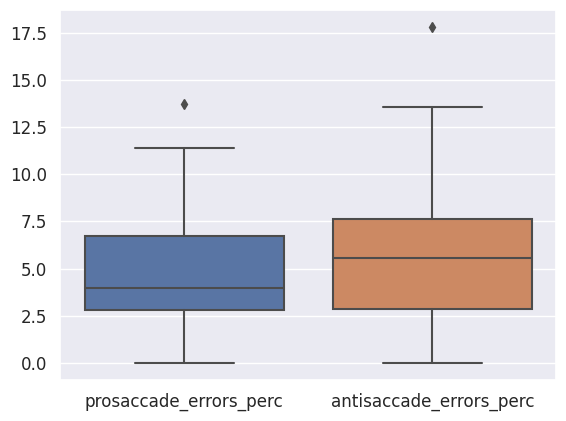

In [19]:
sns.boxplot(data=df_processed_signal[['prosaccade_errors_perc', 'antisaccade_errors_perc']])
print(ranksums(df_processed_signal['prosaccade_errors_perc'], df_processed_signal['antisaccade_errors_perc']))

df_processed_signal[['prosaccade_errors_perc', 'antisaccade_errors_perc']].describe()

In [60]:
len(df_processed_signal['pro_sacc_correct_rt'].iloc[0])

138

### Load all files and separate in blocks
ojo que con este piso al anteriorrrrr

In [77]:
# SEPARACION EN BLOQUES

ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))
REJECTED_SUJ = []
all_dfs = []


print("processing ...")
for i, suj in enumerate(ALL_FILES_RAW):
    df = pd.read_csv(suj)
    if suj in REJECTED_SUJ:
        continue
    suj = str(suj).split("/")[-1].split(".")[0].split("_")[-1]

    df_processed_signal = pd.DataFrame(
        {
            "subject": None,
            "prosaccade": None,
            "antisaccade": None,
            "prosaccade_errors": None,
            "antisaccade_errors": None,
        },
        index=[],
    )

    subjects = []
    prosaccade_trials_remained = []
    antisaccade_trials_remained = []
    pro_saccades = []
    anti_saccades = []
    pro_saccades_errors = []
    pro_saccades_errors_perc = []
    anti_saccades_errors = []
    anti_saccades_errors_perc = []
    trials_rejected_prosaccade = []
    trials_rejected_antisaccade = []
    pro_sacc_errors_rt = []
    pro_sacc_correct_rt = []
    anti_sacc_errors_rt = []
    anti_sacc_correct_rt = []
    age = []
    px2degree = []
    block_number = []

    print(suj)


    for block in range(1, 17):
        anti_saccade_dict = pre_processing(
            df,
            type_of_saccade="antisaccade",
            interpolate=True,
            filter_by_block=True,
            selected_block=block,
        )
        pro_saccade_dict = pre_processing(
            df,
            type_of_saccade="prosaccade",
            interpolate=True,
            filter_by_block=True,
            selected_block=block
        )
        subjects.append(suj)
        pro_saccades.append(pro_saccade_dict["ts_xs"])
        anti_saccades.append(anti_saccade_dict["ts_xs"])

        prosaccade_trials_remained.append(pro_saccade_dict["number_of_trials_remained"])
        antisaccade_trials_remained.append(anti_saccade_dict["number_of_trials_remained"])
    
        pro_saccades_errors.append(pro_saccade_dict["pro_sacc_errors"])
        pro_saccades_errors_perc.append(pro_saccade_dict["pro_sacc_errors_perc"])
        anti_saccades_errors.append(anti_saccade_dict["anti_sacc_errors"])
        anti_saccades_errors_perc.append(anti_saccade_dict["anti_sacc_errors_perc"])
        trials_rejected_prosaccade.append(pro_saccade_dict["trials_rejected"])
        trials_rejected_antisaccade.append(anti_saccade_dict["trials_rejected"])
        pro_sacc_errors_rt.append(pro_saccade_dict["pro_sacc_errors_rt"])
        pro_sacc_correct_rt.append(pro_saccade_dict["pro_sacc_correct_rt"])
        anti_sacc_errors_rt.append(anti_saccade_dict["anti_sacc_errors_rt"])
        anti_sacc_correct_rt.append(anti_saccade_dict["anti_sacc_correct_rt"])
        age.append(anti_saccade_dict["age"])
        px2degree.append(pro_saccade_dict["px2degree"])
        block_number.append(block)
        # print(" --- ")

    df_processed_signal["subject"] = subjects
    df_processed_signal["prosaccade"] = pro_saccades
    df_processed_signal["antisaccade"] = anti_saccades
    df_processed_signal["prosaccade_errors"] = pro_saccades_errors
    df_processed_signal["antisaccade_errors"] = anti_saccades_errors
    df_processed_signal["delta_errors"] = np.array(anti_saccades_errors) - np.array(
        pro_saccades_errors
    )
    df_processed_signal[
        "trials_rejected_antisaccade_percentage"
    ] = trials_rejected_antisaccade
    df_processed_signal[
        "trials_rejected_prosaccade_percentage"
    ] = trials_rejected_prosaccade
    df_processed_signal["pro_sacc_errors_rt"] = pro_sacc_errors_rt
    df_processed_signal["pro_sacc_correct_rt"] = pro_sacc_correct_rt
    df_processed_signal["anti_sacc_errors_rt"] = anti_sacc_errors_rt
    df_processed_signal["anti_sacc_correct_rt"] = anti_sacc_correct_rt

    # median
    df_processed_signal["pro_sacc_errors_rt_median"] = df_processed_signal[
        "pro_sacc_errors_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    df_processed_signal["pro_sacc_correct_rt_median"] = df_processed_signal[
        "pro_sacc_correct_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    df_processed_signal["anti_sacc_errors_rt_median"] = df_processed_signal[
        "anti_sacc_errors_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    df_processed_signal["anti_sacc_correct_rt_median"] = df_processed_signal[
        "anti_sacc_correct_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))

    # Percentage of errors
    df_processed_signal["prosaccade_errors_perc"] = pro_saccades_errors_perc
    df_processed_signal["antisaccade_errors_perc"] = anti_saccades_errors_perc

    df_processed_signal["prosaccade_trials_remained"] = prosaccade_trials_remained
    df_processed_signal["antisaccade_trials_remained"] = antisaccade_trials_remained


    df_processed_signal["age"] = age
    df_processed_signal["px2degree"] = px2degree
    df_processed_signal['block'] = block_number


    all_dfs.append(df_processed_signal)

print(" ")
print("all_dfs ready✅")

df_all_blocks = pd.concat(all_dfs)
df_all_blocks.head(2)

processing ...
111


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


119


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


112


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


118


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


107


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


125


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


113


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


114


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


109


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


110


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


98


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


126


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


91


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


123


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


117


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


103


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


124


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


102


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


92


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


99


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


105


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


115


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


101


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


100


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


104
 
all_dfs ready✅


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,subject,prosaccade,antisaccade,prosaccade_errors,antisaccade_errors,delta_errors,trials_rejected_antisaccade_percentage,trials_rejected_prosaccade_percentage,pro_sacc_errors_rt,pro_sacc_correct_rt,anti_sacc_errors_rt,anti_sacc_correct_rt,pro_sacc_errors_rt_median,pro_sacc_correct_rt_median,anti_sacc_errors_rt_median,anti_sacc_correct_rt_median,prosaccade_errors_perc,antisaccade_errors_perc,prosaccade_trials_remained,antisaccade_trials_remained,age,px2degree,block
0,111,"[([-200.0, -164.20689655172413, -128.413793103...",[],8,0,-8,100.0,15.0,"[549.48, 444.69, 442.72, 528.48, 512.55, 480.0...","[408.48, 464.34, 548.03, 395.59, 501.38, 547.2...",[],[],496.275,441.79,NaN,NaN,47.058824,NaN,17,0,30,30.44,1
1,111,[],"[([-200.0, -165.17241379310343, -130.344827586...",0,3,3,5.0,100.0,[],[],"[340.52, 737.55, 142.76]","[392.07, 397.34, 375.07, 384.45, 532.10, 481.3...",NaN,NaN,340.52,433.67,NaN,15.789474,0,19,30,30.44,2


In [78]:
df_all_blocks.query("subject == '115' and block <= 8").groupby("subject").agg(
        {
            "prosaccade_errors": "sum",
            "antisaccade_errors": "sum",
            "prosaccade_trials_remained": "sum",
            "antisaccade_trials_remained": "sum",
            "pro_sacc_errors_rt": "sum",
            "pro_sacc_correct_rt": "sum",
            "anti_sacc_errors_rt": "sum",
            "anti_sacc_correct_rt": "sum",
            "pro_sacc_errors_rt_median": np.nanmean,
            "anti_sacc_errors_rt_median": np.nanmean,
            "pro_sacc_correct_rt_median": np.nanmean,
            "anti_sacc_correct_rt_median": np.nanmean,
            "block": lambda x: x.nunique(),
        }
    )

,prosaccade_errors,antisaccade_errors,prosaccade_trials_remained,antisaccade_trials_remained,pro_sacc_errors_rt,pro_sacc_correct_rt,anti_sacc_errors_rt,anti_sacc_correct_rt,pro_sacc_errors_rt_median,anti_sacc_errors_rt_median,pro_sacc_correct_rt_median,anti_sacc_correct_rt_median,block
subject,,,,,,,,,,,,,
115,1,8,77,78,[815.00],"[385.62, 487.59, 490.34, 425.66, 464.34, 450.5...","[374.34, 759.72, 368.62, 370.38, 336.90, 810.0...","[570.00, 465.66, 548.00, 429.38, 427.52, 495.1...",815.0,442.7875,422.63,434.00875,8


In [80]:
(1/77) * 100

1.2987012987012987

In [64]:
df_all_blocks.query("subject == '115'")

,subject,prosaccade,antisaccade,prosaccade_errors,antisaccade_errors,delta_errors,trials_rejected_antisaccade_percentage,trials_rejected_prosaccade_percentage,pro_sacc_errors_rt,pro_sacc_correct_rt,anti_sacc_errors_rt,anti_sacc_correct_rt,pro_sacc_errors_rt_median,pro_sacc_correct_rt_median,anti_sacc_errors_rt_median,anti_sacc_correct_rt_median,prosaccade_errors_perc,antisaccade_errors_perc,prosaccade_trials_remained,antisaccade_trials_remained,age,px2degree,block
0,115,"[([-200.0, -165.55172413793105, -131.103448275...",[],1,0,-1,100.0,0.0,[815.00],"[385.62, 487.59, 490.34, 425.66, 464.34, 450.5...",[],[],815.000,425.660,NaN,NaN,5.000000,NaN,20,0,25,29.63,1
1,115,[],"[([-200.0, -165.0, -130.0, -95.0, -60.0, -25.0...",0,2,2,0.0,100.0,[],[],"[374.34, 759.72]","[570.00, 465.66, 548.00, 429.38, 427.52, 495.1...",NaN,NaN,567.03,445.740,NaN,10.000000,0,20,25,29.63,2
2,115,"[([-200.0, -165.31034482758622, -130.620689655...",[],0,0,0,100.0,5.0,[],"[459.10, 364.97, 434.34, 418.21, 397.34, 403.2...",[],[],NaN,420.690,NaN,NaN,0.000000,NaN,19,0,25,29.63,3
3,115,[],"[([-200.0, -165.31034482758622, -130.620689655...",0,2,2,0.0,100.0,[],[],"[368.62, 370.38]","[459.10, 453.21, 385.03, 529.21, 403.31, 394.4...",NaN,NaN,369.50,400.915,NaN,10.000000,0,20,25,29.63,4
4,115,"[([-200.0, -166.0344827586207, -132.0689655172...",[],0,0,0,100.0,0.0,[],"[411.38, 373.31, 444.28, 350.07, 385.03, 390.9...",[],[],NaN,411.690,NaN,NaN,0.000000,NaN,20,0,25,29.63,5
5,115,[],"[([-200.0, -166.24137931034483, -132.482758620...",0,2,2,5.0,100.0,[],[],"[336.90, 810.00]","[475.17, 451.24, 389.14, 453.21, 360.55, 413.2...",NaN,NaN,573.45,436.830,NaN,10.526316,0,19,25,29.63,6
6,115,"[([-200.0, -165.89655172413794, -131.793103448...",[],0,0,0,100.0,10.0,[],"[447.97, 421.31, 459.10, 438.69, 428.14, 549.5...",[],[],NaN,432.480,NaN,NaN,0.000000,NaN,18,0,25,29.63,7
7,115,[],"[([-200.0, -164.51724137931035, -129.034482758...",0,2,2,5.0,100.0,[],[],"[413.86, 108.48]","[474.17, 403.21, 418.83, 420.69, 426.90, 456.4...",NaN,NaN,261.17,452.550,NaN,10.526316,0,19,25,29.63,8
8,115,"[([-200.0, -165.72413793103448, -131.448275862...",[],2,0,-2,100.0,0.0,"[773.00, 795.00]","[485.52, 484.14, 373.31, 494.48, 416.34, 529.2...",[],[],784.000,419.760,NaN,NaN,10.000000,NaN,20,0,25,29.63,9
9,115,[],"[([-200.0, -165.24137931034483, -130.482758620...",0,3,3,10.0,100.0,[],[],"[342.90, 341.24, 367.72]","[356.14, 392.07, 385.62, 488.28, 425.03, 449.2...",NaN,NaN,342.90,402.620,NaN,16.666667,0,18,25,29.63,10


subject
100     5
101     2
102     3
103     6
104     5
105     1
107     3
109     9
110     5
111     7
112     3
113     1
114     4
115     8
117     6
118     2
119    21
123     8
124     0
125     0
126     4
91      2
92      7
98      3
99      5
Name: antisaccade_errors, dtype: int64

subject
100    65
101    62
102    76
103    77
104    78
105    78
107    73
109    73
110    63
111    76
112    79
113    79
114    77
115    78
117    79
118    70
119    62
123    79
124    75
125    51
126    80
91     66
92     76
98     70
99     72
Name: antisaccade_trials_remained, dtype: int64

RanksumsResult(statistic=-1.697749375254331, pvalue=0.08955507441364255)
N=25, blocks=16


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


,prosaccade_errors,antisaccade_errors,prosaccade_trials_remained,antisaccade_trials_remained,pro_sacc_errors_rt,pro_sacc_correct_rt,anti_sacc_errors_rt,anti_sacc_correct_rt,pro_sacc_errors_rt_median,anti_sacc_errors_rt_median,pro_sacc_correct_rt_median,anti_sacc_correct_rt_median,remained_blocks,prosaccade_errors_perc,antisaccade_errors_perc
subject,,,,,,,,,,,,,,,
100,5,5,76,65,"[461.72, 389.72, 110.34, 111.90, 345.66]","[390.31, 409.66, 450.59, 419.45, 427.52, 390.3...","[193.72, 390.90, 396.17, 363.31, 364.97]","[457.14, 473.52, 514.72, 472.21, 491.03, 542.2...",254.946667,317.131667,425.621250,466.647500,8,6.578947,7.692308
101,0,2,63,62,[],"[424.41, 369.21, 416.34, 372.69, 549.52, 499.3...","[383.86, 175.90]","[492.41, 532.83, 461.72, 551.03, 466.31, 546.4...",NaN,279.880000,447.612500,479.853750,8,0.000000,3.225806
102,1,3,58,76,[313.10],"[447.31, 537.17, 526.31, 528.48, 562.41, 500.6...","[290.97, 115.00, 388.55]","[462.38, 522.69, 517.62, 527.03, 542.69, 468.2...",313.100000,264.840000,450.113333,469.208750,7,1.724138,3.947368
103,3,6,80,77,"[452.55, 538.62, 390.90]","[471.55, 444.69, 392.07, 419.45, 429.38, 564.6...","[314.14, 333.79, 367.72, 381.52, 377.41, 420.07]","[462.38, 508.28, 502.76, 537.38, 499.31, 594.6...",458.655000,377.775000,414.861250,449.336250,8,3.750000,7.792208
104,2,5,77,78,"[600.24, 118.10]","[337.41, 383.28, 347.31, 416.97, 396.17, 371.5...","[370.97, 323.97, 335.72, 391.48, 324.48]","[536.45, 558.62, 586.76, 509.66, 457.79, 459.1...",359.170000,352.931667,384.368750,448.111250,8,2.597403,6.410256
105,0,1,76,78,[],"[398.52, 392.07, 552.55, 563.17, 425.66, 442.0...",[350.62],"[514.48, 521.24, 499.31, 506.03, 479.31, 468.2...",NaN,350.620000,468.752500,472.492500,8,0.000000,1.282051
107,5,3,78,73,"[758.76, 495.86, 431.86, 404.38, 390.31]","[390.90, 396.76, 440.55, 355.59, 420.07, 410.1...","[544.41, 377.10, 758.97]","[368.83, 433.10, 449.28, 450.59, 488.97, 417.5...",515.845000,609.862500,414.072500,434.318750,8,6.410256,4.109589
109,3,9,76,73,"[489.66, 330.17, 726.14]","[362.76, 518.62, 508.97, 499.31, 521.97, 457.7...","[418.83, 396.17, 379.76, 557.86, 342.34, 404.9...","[537.90, 549.48, 478.62, 496.55, 456.48, 379.1...",508.907500,393.195000,447.896250,478.102500,8,3.947368,12.328767
110,2,5,70,63,"[150.00, 219.59]","[433.72, 470.24, 434.97, 445.52, 461.07, 416.9...","[396.17, 346.21, 119.03, 455.83, 541.93]","[508.21, 397.93, 415.10, 507.48, 440.55, 442.7...",184.795000,456.560000,446.192500,468.930000,8,2.857143,7.936508


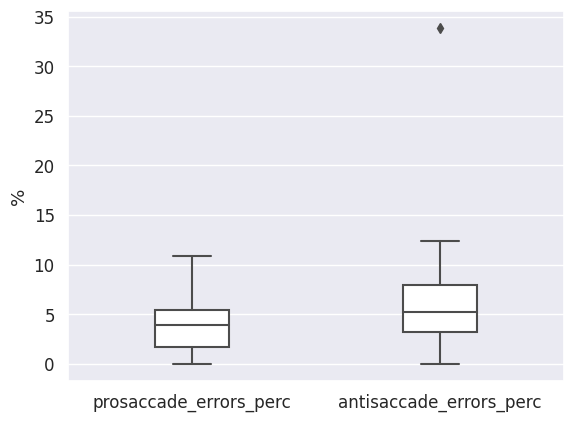

In [81]:
# # Creo que podria sacar este sujeto porque se ve como outlier en el boxplot
# df_all_blocks = df_all_blocks.query("subject != '118'")
# df_all_blocks = df_all_blocks.query("subject != '119'")

# filtrar bloques
MAX_NUMBER_INCORRECTS_PER_BLOCK = (
    18  # Esto implica que en un bloque hizo al menos el 90% mal
)
BLOCKS_NUMBER = 8

df_blocks_filtered = (
    # df_all_blocks.query(
    #     "prosaccade_errors < @MAX_NUMBER_INCORRECTS_PER_BLOCK and antisaccade_errors < @MAX_NUMBER_INCORRECTS_PER_BLOCK"
    # )
    df_all_blocks.query(
        "prosaccade_errors < @MAX_NUMBER_INCORRECTS_PER_BLOCK and antisaccade_errors < @MAX_NUMBER_INCORRECTS_PER_BLOCK and block <= @BLOCKS_NUMBER"
    )  # Con la mitad de los bloques
    .groupby("subject")
    .agg(
        {
            "prosaccade_errors": "sum",
            "antisaccade_errors": "sum",
            "prosaccade_trials_remained": "sum",
            "antisaccade_trials_remained": "sum",
            "pro_sacc_errors_rt": "sum",
            "pro_sacc_correct_rt": "sum",
            "anti_sacc_errors_rt": "sum",
            "anti_sacc_correct_rt": "sum",
            "pro_sacc_errors_rt_median": np.nanmean,
            "anti_sacc_errors_rt_median": np.nanmean,
            "pro_sacc_correct_rt_median": np.nanmean,
            "anti_sacc_correct_rt_median": np.nanmean,
            "block": lambda x: x.nunique(),
        }
    )
)

df_blocks_filtered = df_blocks_filtered.rename({"block": "remained_blocks"}, axis=1)


# Percentage
df_blocks_filtered["prosaccade_errors_perc"] = (
    df_blocks_filtered["prosaccade_errors"]
    / df_blocks_filtered["prosaccade_trials_remained"]
) * 100


df_blocks_filtered["antisaccade_errors_perc"] = (
    df_blocks_filtered["antisaccade_errors"]
    / df_blocks_filtered["antisaccade_trials_remained"]
) * 100


display(df_blocks_filtered["antisaccade_errors"])
display(df_blocks_filtered["antisaccade_trials_remained"])

# Plot
ax = sns.boxplot(
    data=df_blocks_filtered[["prosaccade_errors_perc", "antisaccade_errors_perc"]],
    width=0.3,
)
ax.set_ylabel("%")

boxes = ax.patches
"block"
for i, box in enumerate(boxes):
    box.set_facecolor("w")


print(
    ranksums(
        df_blocks_filtered["prosaccade_errors"],
        df_blocks_filtered["antisaccade_errors"],
    )
)
print(f"N={len(df_blocks_filtered)}, blocks={df_all_blocks['block'].max()}")

df_blocks_filtered.describe()
df_blocks_filtered


In [75]:
1/33

0.030303030303030304

In [74]:
2.32 * 4

9.28

In [38]:
df_blocks_filtered

,prosaccade_errors,antisaccade_errors,prosaccade_trials_remained,antisaccade_trials_remained,pro_sacc_errors_rt,pro_sacc_correct_rt,anti_sacc_errors_rt,anti_sacc_correct_rt,pro_sacc_errors_rt_median,anti_sacc_errors_rt_median,pro_sacc_correct_rt_median,anti_sacc_correct_rt_median,remained_blocks,prosaccade_errors_perc,antisaccade_errors_perc
subject,,,,,,,,,,,,,,,
100,10,8,149,133,"[461.72, 389.72, 110.34, 111.90, 345.66, 375.0...","[390.31, 409.66, 450.59, 419.45, 427.52, 390.3...","[193.72, 390.90, 396.17, 363.31, 364.97, 327.5...","[457.14, 473.52, 514.72, 472.21, 491.03, 542.2...",279.734000,316.479167,419.656250,458.920625,16,6.711409,6.015038
101,4,7,133,126,"[101.97, 318.28, 149.66, 555.59]","[424.41, 369.21, 416.34, 372.69, 549.52, 499.3...","[383.86, 175.90, 180.83, 387.97, 180.83, 149.3...","[492.41, 532.83, 461.72, 551.03, 466.31, 546.4...",281.375000,243.277000,419.656250,467.883750,16,3.007519,5.555556
102,3,6,135,155,"[313.10, 179.31, 785.00]","[447.31, 537.17, 526.31, 528.48, 562.41, 500.6...","[290.97, 115.00, 388.55, 438.07, 536.45, 376.83]","[462.38, 522.69, 517.62, 527.03, 542.69, 468.2...",425.803333,357.645000,429.107857,459.134375,15,2.222222,3.870968
103,6,14,151,154,"[452.55, 538.62, 390.90, 693.97, 741.38, 118.41]","[471.55, 444.69, 392.07, 419.45, 429.38, 564.6...","[314.14, 333.79, 367.72, 381.52, 377.41, 420.0...","[462.38, 508.28, 502.76, 537.38, 499.31, 594.6...",494.214000,323.560714,393.250000,424.753750,16,3.973510,9.090909
104,7,12,153,157,"[600.24, 118.10, 763.59, 310.00, 808.00, 289.0...","[337.41, 383.28, 347.31, 416.97, 396.17, 371.5...","[370.97, 323.97, 335.72, 391.48, 324.48, 250.5...","[536.45, 558.62, 586.76, 509.66, 457.79, 459.1...",438.269167,326.252500,360.138750,416.073750,16,4.575163,7.643312
105,2,4,149,158,"[361.10, 216.28]","[398.52, 392.07, 552.55, 563.17, 425.66, 442.0...","[350.62, 337.93, 487.59, 731.97]","[514.48, 521.24, 499.31, 506.03, 479.31, 468.2...",288.690000,432.776667,453.410625,453.828750,16,1.342282,2.531646
107,5,7,150,148,"[758.76, 495.86, 431.86, 404.38, 390.31]","[390.90, 396.76, 440.55, 355.59, 420.07, 410.1...","[544.41, 377.10, 758.97, 361.66, 360.00, 375.0...","[368.83, 433.10, 449.28, 450.59, 488.97, 417.5...",515.845000,423.243750,405.105000,428.030000,16,3.333333,4.729730
109,5,17,150,141,"[489.66, 330.17, 726.14, 433.10, 488.97]","[362.76, 518.62, 508.97, 499.31, 521.97, 457.7...","[418.83, 396.17, 379.76, 557.86, 342.34, 404.9...","[537.90, 549.48, 478.62, 496.55, 456.48, 379.1...",484.971250,389.121429,425.408125,451.625000,16,3.333333,12.056738
110,8,6,146,134,"[150.00, 219.59, 331.21, 784.83, 353.38, 386.2...","[433.72, 470.24, 434.97, 445.52, 461.07, 416.9...","[396.17, 346.21, 119.03, 455.83, 541.93, 529.21]","[508.21, 397.93, 415.10, 507.48, 440.55, 442.7...",338.716000,480.776667,432.256875,453.378750,16,5.479452,4.477612


In [28]:
boxplot_stats(df_blocks_filtered['antisaccade_errors']).pop(0)['fliers']

array([26.25])

In [ ]:
## Idea, revisar por 
for block in range(1,17):
    sns.boxplot(df_all_blocks.query("block == @block")[["prosaccade_errors", "antisaccade_errors"]])
    plt.title(f"block: {block}")
    plt.show()

/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


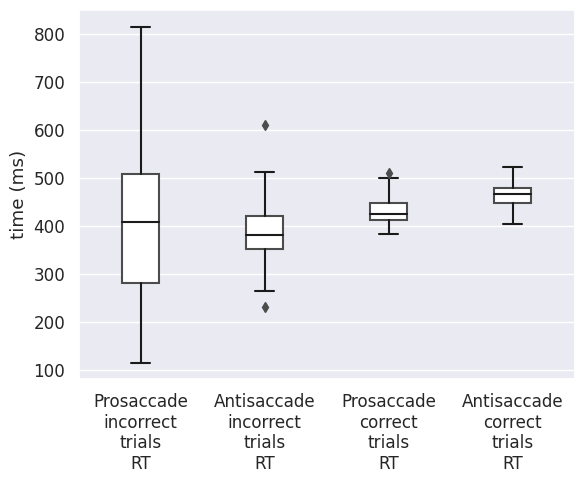

RT condition [pro - anti] x result [correct - incorrect]
ranksums pro_sacc_errors_rt_median vs. anti_sacc_errors_rt_median:  0.52493
ranksums pro_sacc_correct_rt_median vs. anti_sacc_correct_rt_median: 0.00011



,prosaccade_errors,antisaccade_errors,prosaccade_trials_remained,antisaccade_trials_remained,pro_sacc_errors_rt_median,anti_sacc_errors_rt_median,pro_sacc_correct_rt_median,anti_sacc_correct_rt_median,remained_blocks,prosaccade_errors_perc,antisaccade_errors_perc
count,25.000000,25.000000,25.000000,25.000000,22.000000,23.000000,25.000000,25.000000,25.00,25.000000,25.000000
mean,3.040000,4.800000,73.400000,72.560000,409.117784,385.138333,429.296833,465.501967,7.96,4.056296,6.694821
std,2.281812,4.213075,6.103278,7.314825,163.364843,79.682137,32.484553,29.607922,0.20,3.030854,6.564599
min,0.000000,0.000000,56.000000,51.000000,115.310000,230.270000,382.423750,403.148750,7.00,0.000000,0.000000
25%,1.000000,2.000000,72.000000,70.000000,281.086250,351.998333,412.177500,448.111250,8.00,1.724138,3.225806
50%,3.000000,4.000000,75.000000,76.000000,408.370000,381.312500,424.595000,466.647500,8.00,3.947368,5.194805
75%,4.000000,6.000000,77.000000,78.000000,507.108125,420.716250,447.612500,479.853750,8.00,5.405405,7.936508
max,8.000000,21.000000,80.000000,80.000000,815.000000,609.862500,510.742500,522.690000,8.00,10.810811,33.870968


In [31]:
# VERSION CON BLOQUES

# Boxplot with means

ax = sns.boxplot(
    data=df_blocks_filtered[
        [
            "pro_sacc_errors_rt_median",
            "anti_sacc_errors_rt_median",
            "pro_sacc_correct_rt_median",
            "anti_sacc_correct_rt_median",
        ]
    ],
    width=0.3,
)

# # Select which box you want to change
boxes = ax.patches
"block"
for i, box in enumerate(boxes):
    box.set_facecolor("w")
    # if "err" in df_correct_err_rt.columns[i]:
    #     box.set_facecolor("r")
    # else:
    #     box.set_facecolor("b")

# plt.setp(ax.get_xticklabels())
plt.ylabel("time (ms)")
ax.set_xticklabels(
    [
        "Prosaccade\nincorrect\ntrials\nRT",
        "Antisaccade\nincorrect\ntrials\nRT",
        "Prosaccade\ncorrect\ntrials\nRT",
        "Antisaccade\ncorrect\ntrials\nRT",
    ]
)

plt.setp(ax.artists, edgecolor="k", facecolor="w")
plt.setp(ax.lines, color="k")

plt.show()

print(
    f"""RT condition [pro - anti] x result [correct - incorrect]
ranksums pro_sacc_errors_rt_median vs. anti_sacc_errors_rt_median:  {Decimal(ranksums(df_blocks_filtered['pro_sacc_errors_rt_median'],df_blocks_filtered['anti_sacc_errors_rt_median'], nan_policy='omit')[1]):.5f}
ranksums pro_sacc_correct_rt_median vs. anti_sacc_correct_rt_median: {Decimal(ranksums(df_blocks_filtered['pro_sacc_correct_rt_median'],df_blocks_filtered['anti_sacc_correct_rt_median'], nan_policy='omit')[1]):.5f}
"""
)

df_blocks_filtered.describe()

# PROBAR USAR LA MEDIANA DENTRO DE CADA SUJETO.


<AxesSubplot: >

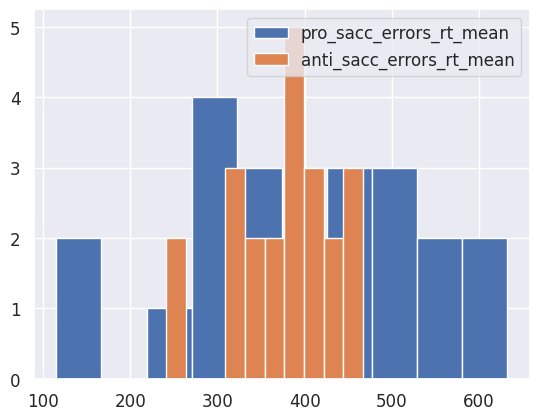

In [253]:


# df_rts_mean['pro_sacc_errors_rt_mean'].plot.kde(legend=True)
# df_rts_mean['anti_sacc_errors_rt_mean'].plot.kde(legend=True)
df_blocks_filtered['pro_sacc_errors_rt_mean'].hist(legend=True, bins=10)
df_blocks_filtered['anti_sacc_errors_rt_mean'].hist(legend=True, bins=10)
# df_rts_mean['pro_sacc_correct_rt_mean'].hist(legend=True, bins=10)
# df_rts_mean['anti_sacc_correct_rt_mean'].hist(legend=True, bins=10)


# HASTA ACA ESTUVE MODIFICANDO, FALTA ADAPTAR CON BLOQUES


Percentage of accepted trials
N=19
ranksums p=1.000


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


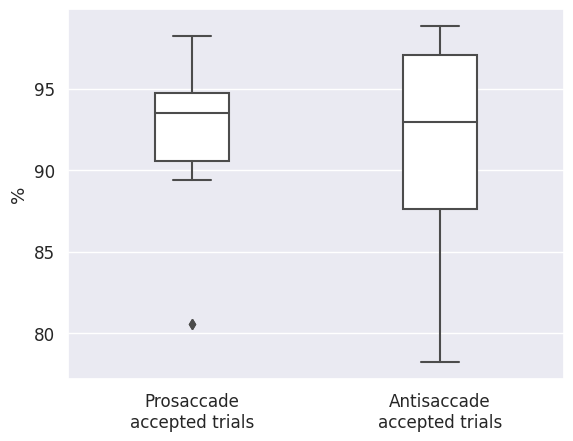

,trials_accepted_prosaccade_perc,trials_accepted_antisaccade_perc
count,19.000000,19.000000
mean,92.136223,91.455108
std,4.727119,6.513135
min,80.588235,78.235294
25%,90.588235,87.647059
50%,93.529412,92.941176
75%,94.705882,97.058824
max,98.235294,98.823529


In [18]:
# HASTA ACA ESTUVE MODIFICANDO, FALTA ADAPTAR CON BLOQUES


df_accepted_trials_perc = 100  - df_processed_signal[[
        "trials_rejected_prosaccade_percentage",
        "trials_rejected_antisaccade_percentage",
    ]]

df_accepted_trials_perc.columns = ['trials_accepted_prosaccade_perc', 'trials_accepted_antisaccade_perc']

df_accepted_trials_perc

ax = sns.boxplot(
    data=df_accepted_trials_perc,
    width=0.3,
)

# # Select which box you want to change
boxes = ax.patches

for i, box in enumerate(boxes):
    box.set_facecolor("w")
print(
    f"""Percentage of accepted trials
N={len(df_accepted_trials_perc)}
ranksums p={(ranksums(df_accepted_trials_perc['trials_accepted_prosaccade_perc'], df_accepted_trials_perc['trials_accepted_antisaccade_perc'])[-1]) :.3f}"""
)

ax.set_xticklabels(
    [
        "Prosaccade\naccepted trials",
        "Antisaccade\naccepted trials",
    ]
)
plt.ylabel('%')
plt.show()

df_accepted_trials_perc.describe()

In [ ]:
df_processed_signal.boxplot(
    column=[
        "trials_rejected_prosaccade_percentage",
        "trials_rejected_antisaccade_percentage",
    ],
    fontsize=15,
    rot=90,
)
print(df_processed_signal.shape)
plt.show()

df_processed_signal[
    [
        "trials_rejected_prosaccade_percentage",
        "trials_rejected_antisaccade_percentage",
    ]
].describe()

print(
    ranksums(
        df_processed_signal["trials_rejected_prosaccade_percentage"],
        df_processed_signal["trials_rejected_antisaccade_percentage"],
    )
)


In [ ]:
df_processed_signal

In [ ]:
# Plot all subjects
for file in enumerate(ALL_FILES_RAW):
    print("---")
    suj = str(file).split("/")[-1].split(".")[0].split("_")[-1]
    print(suj)
    one_subject(df_processed_signal, suj, "prosaccade")
    one_subject(df_processed_signal, suj, "antisaccade")

### Saccade detection


In [ ]:
# def fixations_saccades_detection(raw, et_channels_meg, subject, sac_max_vel=1500, fix_max_amp=1.5,
#                                  screen_size=38, screen_resolution=1920, force_run=False):

out_fname = f"Fix_Sac_detection_{subject.subject_id}.tsv"
out_folder = paths().preproc_path() + subject.subject_id + "/Sac-Fix_detection/"

meg_gazex_data_clean = et_channels_meg[0]
meg_gazey_data_clean = et_channels_meg[1]
meg_pupils_data_clean = et_channels_meg[2]

if not force_run:
    try:
        # Load pre run saccades and fixation detection
        sac_fix = pd.read_csv(out_folder + out_fname, sep="\t")
        print("\nSaccades and fixations loaded")
    except:
        force_run = True

if force_run:
    # If not pre run data, run
    print("\nRunning saccades and fixations detection")

    # Define data to save to excel file needed to run the saccades detection program Remodnav
    eye_data = {"x": meg_gazex_data_clean, "y": meg_gazey_data_clean}
    df = pd.DataFrame(eye_data)

    # Remodnav parameters
    fname = f"eye_data_{subject.subject_id}.csv"
    px2deg = math.degrees(
        math.atan2(0.5 * screen_size, subject.config.preproc.screen_distance)
    ) / (0.5 * screen_resolution)
    sfreq = raw.info["sfreq"]

    # Save csv file
    df.to_csv(fname, sep="\t", header=False, index=False)

    # Run Remodnav not considering pursuit class and min fixations 100 ms
    command = (
        f"remodnav {fname} {out_fname} {px2deg} {sfreq} --savgol-length {0.0195} --min-pursuit-duration {2} "
        f"--max-pso-duration {0.0} --min-fixation-duration {0.05} --max-vel {5000}"
    )
    os.system(command)

    # Read results file with detections
    sac_fix = pd.read_csv(out_fname, sep="\t")

    # Move eye data, detections file and image to subject results directory
    os.makedirs(out_folder, exist_ok=True)
    # Move et data file
    os.replace(fname, out_folder + fname)
    # Move results file
    os.replace(out_fname, out_folder + out_fname)
    # Move results image
    out_fname = out_fname.replace("tsv", "png")
    os.replace(out_fname, out_folder + out_fname)

# Get saccades and fixations
saccades_all = copy.copy(
    sac_fix.loc[(sac_fix["label"] == "SACC") | (sac_fix["label"] == "ISAC")]
)
fixations_all = copy.copy(sac_fix.loc[sac_fix["label"] == "FIXA"])

# Drop saccades and fixations based on conditions
fixations = copy.copy(fixations_all[(fixations_all["amp"] <= fix_max_amp)])
print(
    f"Dropping saccades with average vel > {sac_max_vel}, and fixations with amplitude > {fix_max_amp}"
)

saccades = copy.copy(saccades_all[saccades_all["peak_vel"] <= sac_max_vel])
print(f"Kept {len(fixations)} out of {len(fixations_all)} fixations")
print(f"Kept {len(saccades)} out of {len(saccades_all)} saccades")

subject.len_all_sac = len(saccades_all)
subject.len_all_fix = len(fixations_all)
subject.len_sac_drop = len(saccades)
subject.len_fix_drop = len(fixations)

times = raw.times
mean_x = []
mean_y = []
pupil_size = []
prev_sac = []
next_sac = []

# Remove fixations from and to blink
print("Finding previous and next saccades")
i = 0
for fix_idx, fixation in fixations.iterrows():
    fix_time = fixation["onset"]
    fix_dur = fixation["duration"]

    sacc_thresh = 0.002  # 2 ms
    # Previous and next saccades
    try:
        sac0 = saccades.loc[
            (saccades["onset"] + saccades["duration"] > fix_time - sacc_thresh)
            & (saccades["onset"] + saccades["duration"] < fix_time + sacc_thresh)
        ].index.values[-1]
    except:
        sac0 = None
    prev_sac.append(sac0)

    try:
        sac1 = saccades.loc[
            (saccades["onset"] > fix_time + fix_dur - sacc_thresh)
            & (saccades["onset"] < fix_time + fix_dur + sacc_thresh)
        ].index.values[0]
    except:
        sac1 = None
    next_sac.append(sac1)

    print("\rProgress: {}%".format(int((i + 1) * 100 / len(fixations))), end="")
    i += 1

# Add columns
fixations["prev_sac"] = prev_sac
fixations["next_sac"] = next_sac

# Drop when None
fixations.dropna(subset=["prev_sac"], inplace=True)
print(f"\nKept {len(fixations)} fixations with previous saccade")

print("Computing average pupil size, and x and y position")
i = 0
for fix_idx, fixation in fixations.iterrows():
    fix_time = fixation["onset"]
    fix_dur = fixation["duration"]

    # Average pupil size, x and y position
    fix_time_idx = np.where(
        np.logical_and(fix_time < times, times < fix_time + fix_dur)
    )[0]

    pupil_data_fix = meg_pupils_data_clean[fix_time_idx]
    gazex_data_fix = meg_gazex_data_clean[fix_time_idx]
    gazey_data_fix = meg_gazey_data_clean[fix_time_idx]

    pupil_size.append(np.nanmean(pupil_data_fix))
    mean_x.append(np.nanmean(gazex_data_fix))
    mean_y.append(np.nanmean(gazey_data_fix))

    print("\rProgress: {}%".format(int((i + 1) * 100 / len(fixations))), end="")
    i += 1

fixations["mean_x"] = mean_x
fixations["mean_y"] = mean_y
fixations["pupil"] = pupil_size
fixations = fixations.astype(
    {
        "mean_x": float,
        "mean_y": float,
        "pupil": float,
        "prev_sac": "Int64",
        "next_sac": "Int64",
    }
)


### Other

In [ ]:
# Podemos poner 0 - 150
# Graficar solo los eerrores

# Calcular para cada trial correcto o incorrecto y el tiempo (y promedios +- desvio)
# Tablita cmo en la tesis (2 porcentajes y 4 tiempos)


In [ ]:
# Tiempos en el experimento (ms)

# Inter-trial time (ITI) = 925
# Prensentacion de la cue de tipo de tarea =  getRandomIntInclusive(900, 1500) -> es variable!
# Presentacion del cuadrado central que es igual para todos (cue sin informacion) = 200
# tiempo durante el que aparece la visualCue = 150
# Tiempo para responder (responseAwait) = 650

925 + 1500 + 200 + 150 + 650
